# 癌症诊断分类：K近邻分类器

**作者**: C.C.

使用威斯康星州乳腺肿瘤数据集训练K近邻分类器来预测肿瘤是恶性还是良性。

## 数据集信息
- **数据集**: 威斯康星州乳腺肿瘤数据集 (Wisconsin Breast Cancer Dataset)
- **目标**: 预测肿瘤是恶性(M)还是良性(B)
- **特征**: 30个数值特征，包括半径、纹理、周长、面积等


In [12]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("库导入完成！")


库导入完成！


In [13]:
# 1. 数据加载和探索
print("=== 数据加载和基本信息 ===")
df = pd.read_csv('bc_data.csv')

print(f"数据集形状: {df.shape}")
print(f"列名: {list(df.columns)}")
print("\n前5行数据:")
print(df.head())

print("\n数据类型:")
print(df.dtypes)

print("\n缺失值统计:")
print(df.isnull().sum().sum())

print("\n目标变量分布:")
print(df['diagnosis'].value_counts())
print(f"恶性比例: {df['diagnosis'].value_counts()['M'] / len(df) * 100:.2f}%")
print(f"良性比例: {df['diagnosis'].value_counts()['B'] / len(df) * 100:.2f}%")


=== 数据加载和基本信息 ===
数据集形状: (569, 32)
列名: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']

前5行数据:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      38

=== 数据可视化 ===


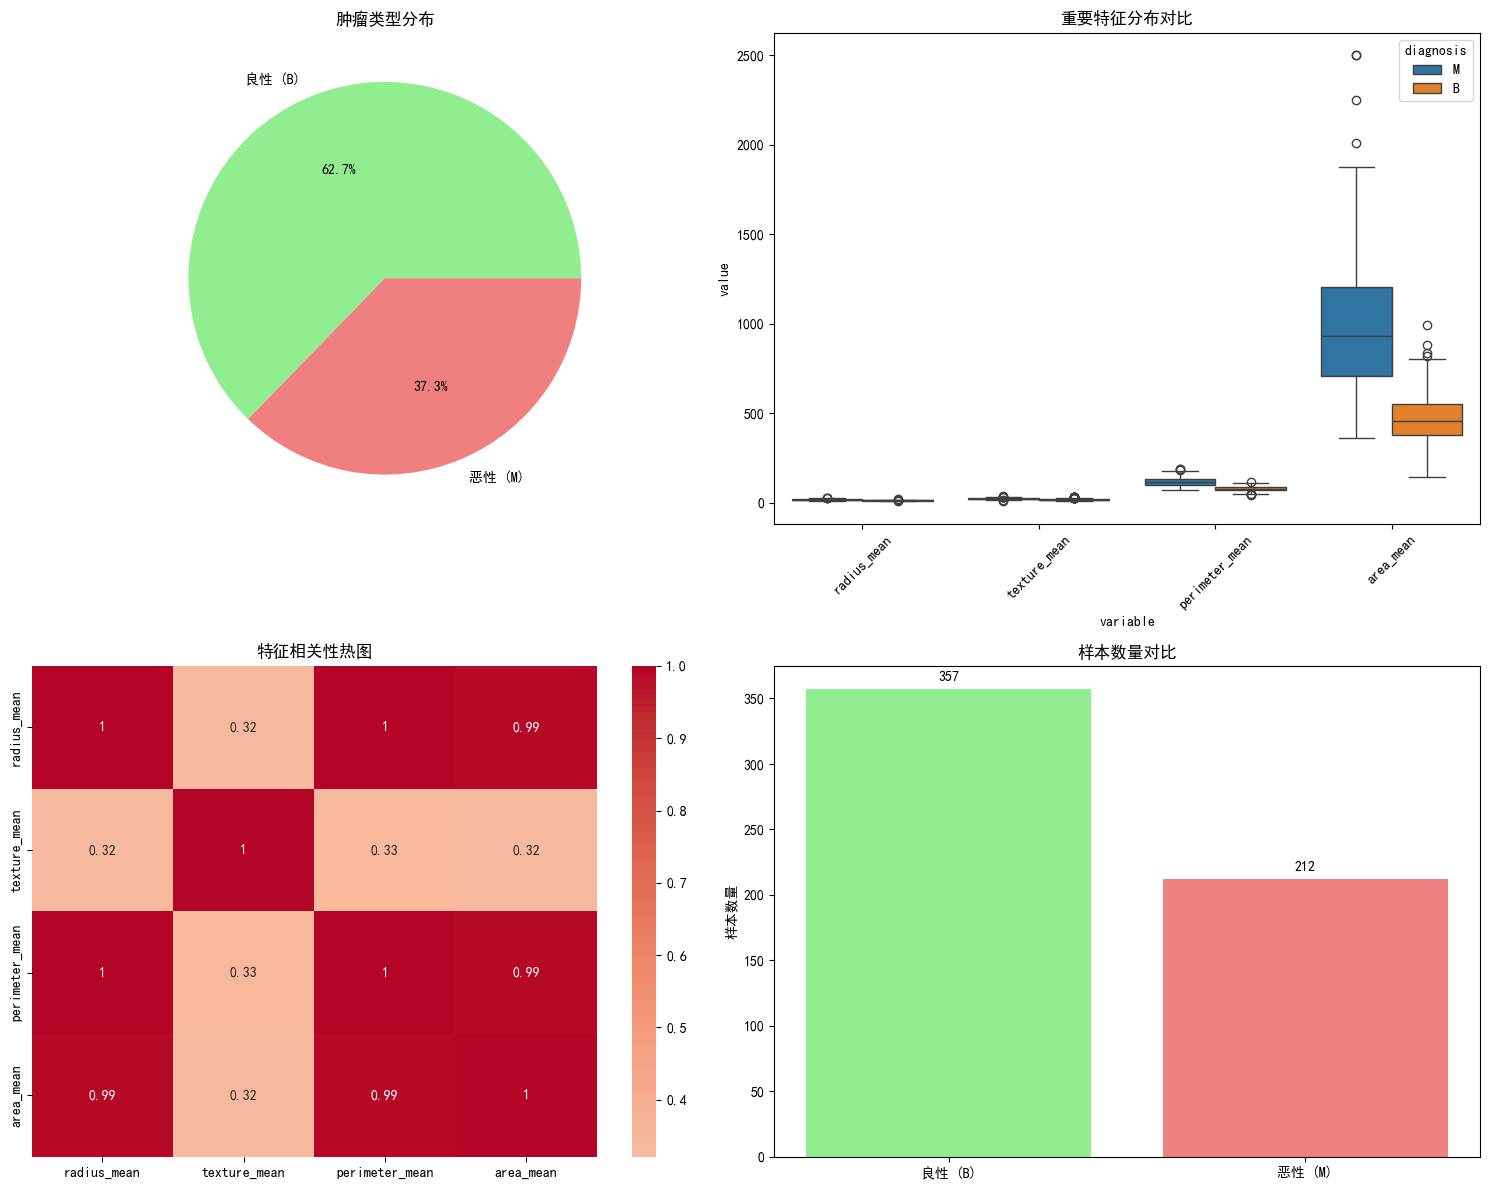

数据集包含 569 个样本
其中良性样本: 357 个
恶性样本: 212 个
数据可视化图片已保存为: data_visualization.png


In [14]:
# 2. 数据可视化
print("=== 数据可视化 ===")

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 目标变量分布
axes[0, 0].pie(df['diagnosis'].value_counts(), labels=['良性 (B)', '恶性 (M)'], 
               autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[0, 0].set_title('肿瘤类型分布')

# 选择几个重要特征进行可视化
important_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']

# 特征分布箱线图
df_melted = df[important_features + ['diagnosis']].melt(id_vars=['diagnosis'], 
                                                       value_vars=important_features)
sns.boxplot(data=df_melted, x='variable', y='value', hue='diagnosis', ax=axes[0, 1])
axes[0, 1].set_title('重要特征分布对比')
axes[0, 1].tick_params(axis='x', rotation=45)

# 特征相关性热图
correlation_matrix = df[important_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
axes[1, 0].set_title('特征相关性热图')

# 恶性vs良性样本数量
diagnosis_counts = df['diagnosis'].value_counts()
axes[1, 1].bar(['良性 (B)', '恶性 (M)'], diagnosis_counts.values, 
               color=['lightgreen', 'lightcoral'])
axes[1, 1].set_title('样本数量对比')
axes[1, 1].set_ylabel('样本数量')

# 在柱状图上添加数值标签
for i, v in enumerate(diagnosis_counts.values):
    axes[1, 1].text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('data_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"数据集包含 {len(df)} 个样本")
print(f"其中良性样本: {diagnosis_counts['B']} 个")
print(f"恶性样本: {diagnosis_counts['M']} 个")
print("数据可视化图片已保存为: data_visualization.png")


In [15]:
# 3. 数据预处理
print("=== 数据预处理 ===")

# 准备特征和目标变量
# 删除id列，保留所有数值特征
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

print(f"特征矩阵形状: {X.shape}")
print(f"目标变量形状: {y.shape}")

# 将目标变量转换为数值 (B=0, M=1)
y_numeric = (y == 'M').astype(int)
print(f"目标变量转换后: 0(良性)={sum(y_numeric==0)}, 1(恶性)={sum(y_numeric==1)}")

# 数据分割：70%训练，30%测试
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.3, random_state=42, stratify=y_numeric
)

print(f"训练集大小: {X_train.shape[0]} 样本")
print(f"测试集大小: {X_test.shape[0]} 样本")
print(f"训练集中恶性样本比例: {y_train.mean():.2%}")
print(f"测试集中恶性样本比例: {y_test.mean():.2%}")

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("特征标准化完成！")
print(f"标准化后训练集形状: {X_train_scaled.shape}")
print(f"标准化后测试集形状: {X_test_scaled.shape}")


=== 数据预处理 ===
特征矩阵形状: (569, 30)
目标变量形状: (569,)
目标变量转换后: 0(良性)=357, 1(恶性)=212
训练集大小: 398 样本
测试集大小: 171 样本
训练集中恶性样本比例: 37.19%
测试集中恶性样本比例: 37.43%
特征标准化完成！
标准化后训练集形状: (398, 30)
标准化后测试集形状: (171, 30)


In [16]:
# 4. K近邻模型训练和参数优化
print("=== K近邻模型训练和参数优化 ===")

# 使用网格搜索找到最佳K值
k_range = list(range(1, 31))
param_grid = {'n_neighbors': k_range}

# 创建KNN分类器
knn = KNeighborsClassifier()

# 使用交叉验证进行网格搜索
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"最佳K值: {grid_search.best_params_['n_neighbors']}")
print(f"最佳交叉验证准确率: {grid_search.best_score_:.4f}")

# 使用最佳参数训练最终模型
best_knn = grid_search.best_estimator_

# 在测试集上进行预测
y_pred = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")

# 不同K值的性能对比
k_scores = []
for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

print(f"K值范围: {min(k_range)} 到 {max(k_range)}")
print(f"最佳K值: {k_range[np.argmax(k_scores)]}")
print(f"最高准确率: {max(k_scores):.4f}")


=== K近邻模型训练和参数优化 ===
最佳K值: 5
最佳交叉验证准确率: 0.9697
测试集准确率: 0.9649
K值范围: 1 到 30
最佳K值: 5
最高准确率: 0.9697


In [17]:
# 5. 模型性能评估
print("=== 模型性能评估 ===")

# 详细分类报告
print("分类报告:")
print(classification_report(y_test, y_pred, target_names=['良性 (B)', '恶性 (M)']))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print(f"\n混淆矩阵:")
print(f"真阴性(TN): {cm[0,0]}, 假阳性(FP): {cm[0,1]}")
print(f"假阴性(FN): {cm[1,0]}, 真阳性(TP): {cm[1,1]}")

# 计算各种指标
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n性能指标:")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"特异性 (Specificity): {specificity:.4f}")
print(f"F1分数: {f1_score:.4f}")

# 交叉验证分数
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=5)
print(f"\n5折交叉验证分数: {cv_scores}")
print(f"交叉验证平均分数: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== 模型性能评估 ===
分类报告:
              precision    recall  f1-score   support

      良性 (B)       0.95      1.00      0.97       107
      恶性 (M)       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171


混淆矩阵:
真阴性(TN): 107, 假阳性(FP): 0
假阴性(FN): 6, 真阳性(TP): 58

性能指标:
准确率 (Accuracy): 0.9649
精确率 (Precision): 1.0000
召回率 (Recall): 0.9062
特异性 (Specificity): 1.0000
F1分数: 0.9508

5折交叉验证分数: [0.9875     0.9875     0.975      0.98734177 0.91139241]
交叉验证平均分数: 0.9697 (+/- 0.0591)


=== 结果可视化 ===


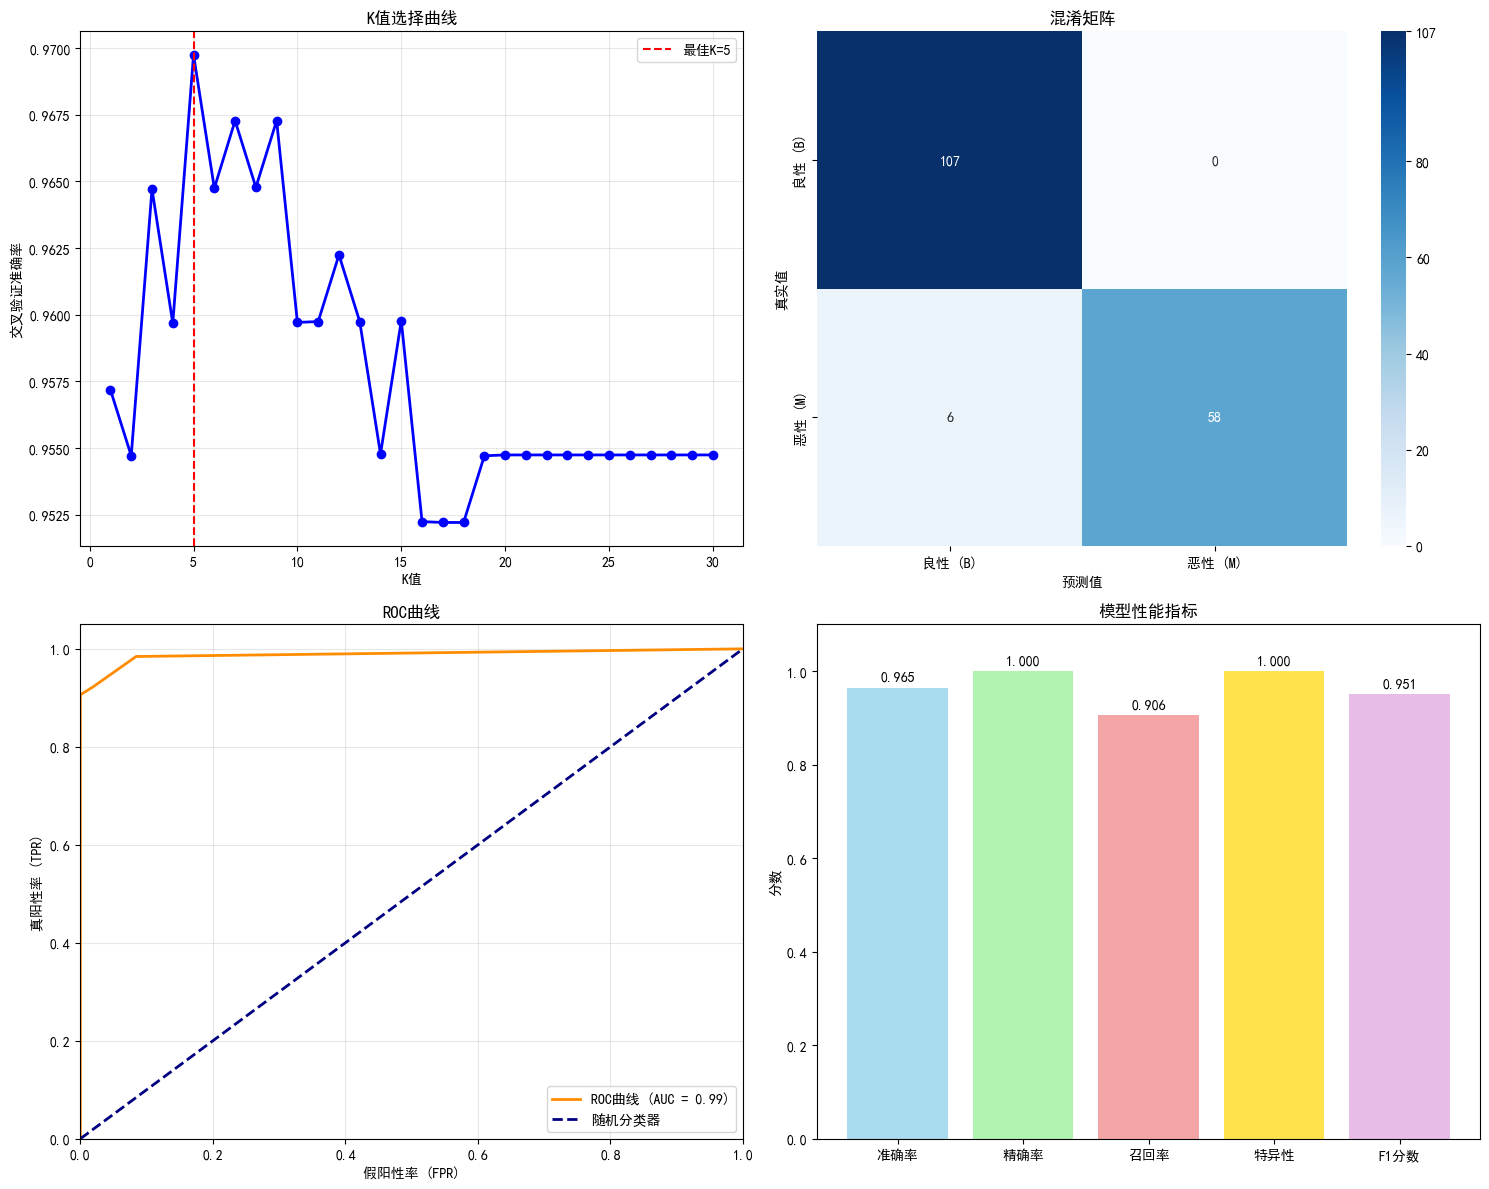

ROC AUC分数: 0.9882
模型在测试集上的整体表现: 优秀
模型结果可视化图片已保存为: model_results_visualization.png


In [18]:
# 6. 结果可视化
print("=== 结果可视化 ===")

# 创建可视化图表
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. K值选择曲线
axes[0, 0].plot(k_range, k_scores, 'b-o', linewidth=2, markersize=6)
axes[0, 0].axvline(x=grid_search.best_params_['n_neighbors'], color='r', linestyle='--', 
                   label=f'最佳K={grid_search.best_params_["n_neighbors"]}')
axes[0, 0].set_xlabel('K值')
axes[0, 0].set_ylabel('交叉验证准确率')
axes[0, 0].set_title('K值选择曲线')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. 混淆矩阵热图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['良性 (B)', '恶性 (M)'],
            yticklabels=['良性 (B)', '恶性 (M)'], ax=axes[0, 1])
axes[0, 1].set_title('混淆矩阵')
axes[0, 1].set_xlabel('预测值')
axes[0, 1].set_ylabel('真实值')

# 3. ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC曲线 (AUC = {roc_auc:.2f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机分类器')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('假阳性率 (FPR)')
axes[1, 0].set_ylabel('真阳性率 (TPR)')
axes[1, 0].set_title('ROC曲线')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True, alpha=0.3)

# 4. 性能指标柱状图
metrics = ['准确率', '精确率', '召回率', '特异性', 'F1分数']
values = [accuracy, precision, recall, specificity, f1_score]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']

bars = axes[1, 1].bar(metrics, values, color=colors, alpha=0.7)
axes[1, 1].set_ylabel('分数')
axes[1, 1].set_title('模型性能指标')
axes[1, 1].set_ylim(0, 1)

# 在柱状图上添加数值标签
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('model_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC AUC分数: {roc_auc:.4f}")
print(f"模型在测试集上的整体表现: {'优秀' if accuracy > 0.95 else '良好' if accuracy > 0.90 else '一般'}")
print("模型结果可视化图片已保存为: model_results_visualization.png")


=== 保存单独图表 ===


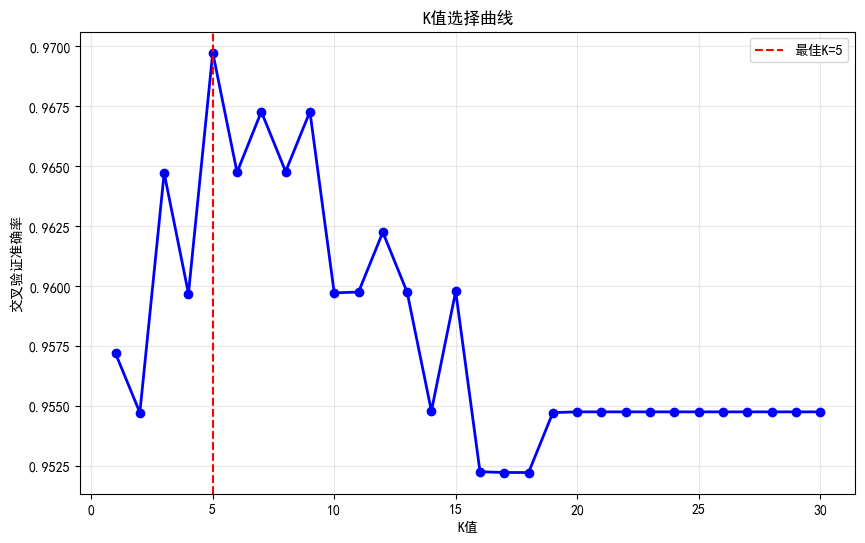

K值选择曲线已保存为: k_value_selection.png


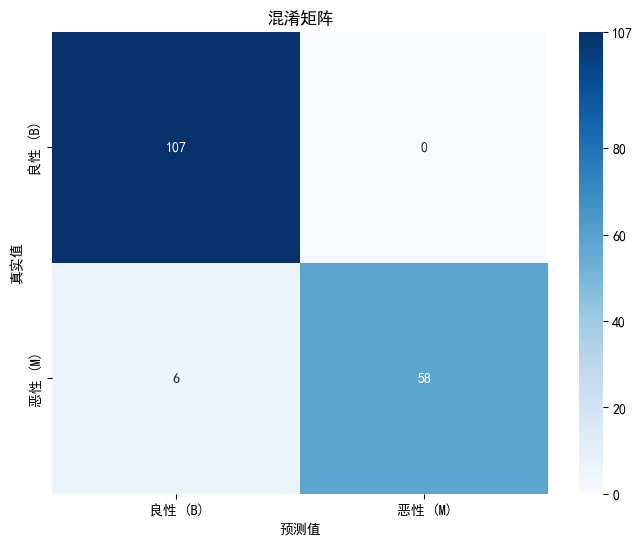

混淆矩阵已保存为: confusion_matrix.png


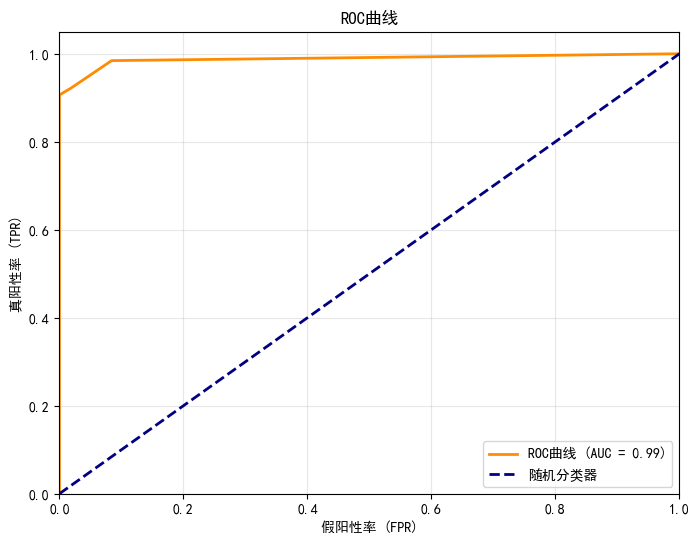

ROC曲线已保存为: roc_curve.png


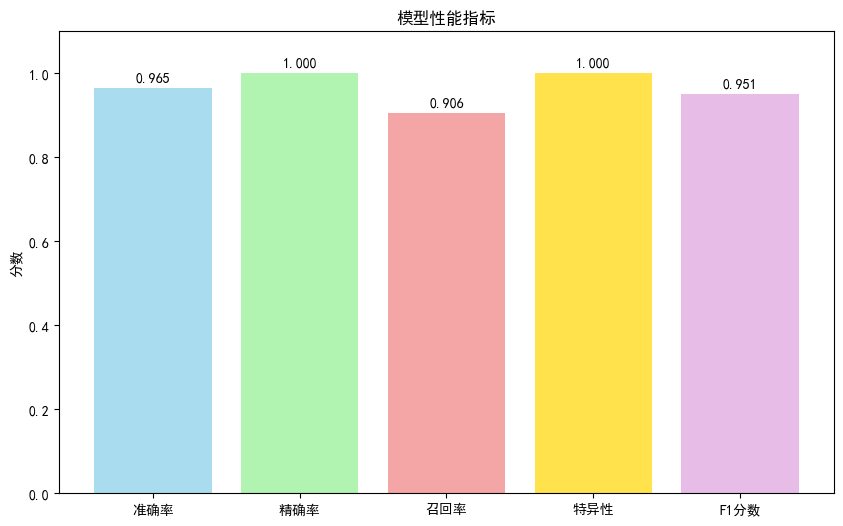

性能指标柱状图已保存为: performance_metrics.png

所有图表已成功保存到根目录！


In [19]:
# 8. 单独保存各个图表
print("=== 保存单独图表 ===")

# 1. 保存K值选择曲线
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, 'b-o', linewidth=2, markersize=6)
plt.axvline(x=grid_search.best_params_['n_neighbors'], color='r', linestyle='--', 
           label=f'最佳K={grid_search.best_params_["n_neighbors"]}')
plt.xlabel('K值')
plt.ylabel('交叉验证准确率')
plt.title('K值选择曲线')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('k_value_selection.png', dpi=300, bbox_inches='tight')
plt.show()
print("K值选择曲线已保存为: k_value_selection.png")

# 2. 保存混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['良性 (B)', '恶性 (M)'],
            yticklabels=['良性 (B)', '恶性 (M)'],
            cbar_kws={'ticks': [0, 20, 40, 60, 80, max(cm.flatten())]})
plt.title('混淆矩阵')
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("混淆矩阵已保存为: confusion_matrix.png")

# 3. 保存ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC曲线 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机分类器')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 (FPR)')
plt.ylabel('真阳性率 (TPR)')
plt.title('ROC曲线')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC曲线已保存为: roc_curve.png")

# 4. 保存性能指标柱状图
plt.figure(figsize=(10, 6))
metrics = ['准确率', '精确率', '召回率', '特异性', 'F1分数']
values = [accuracy, precision, recall, specificity, f1_score]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylabel('分数')
plt.title('模型性能指标')
# 移除上限限制，让y轴自动调整
plt.ylim(0, max(values) * 1.1)  # 设置为最大值的1.1倍

# 在柱状图上添加数值标签
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("性能指标柱状图已保存为: performance_metrics.png")

print("\n所有图表已成功保存到根目录！")


=== 保存数据分布图表 ===


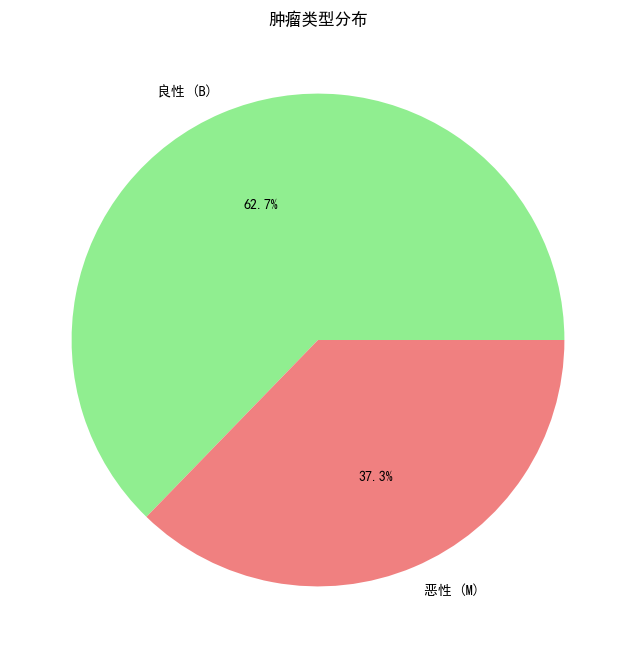

肿瘤类型分布饼图已保存为: tumor_type_distribution.png


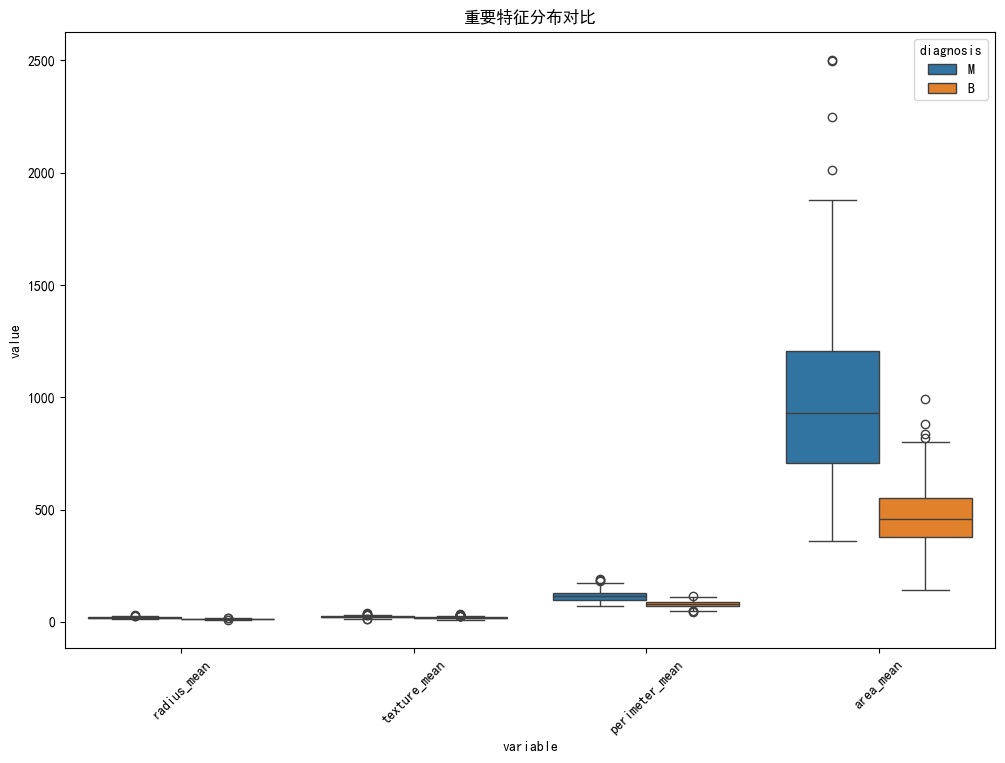

特征分布箱线图已保存为: feature_distribution_boxplot.png


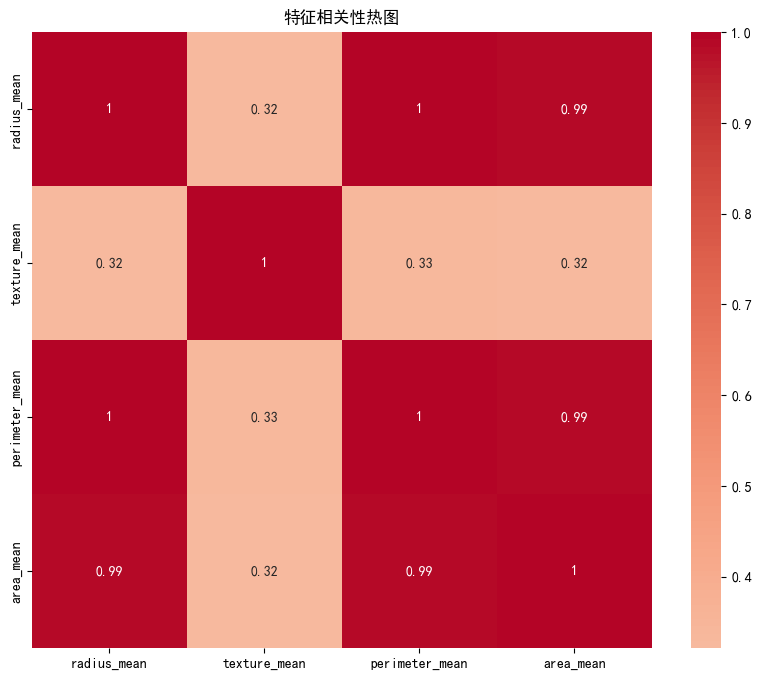

特征相关性热图已保存为: feature_correlation_heatmap.png


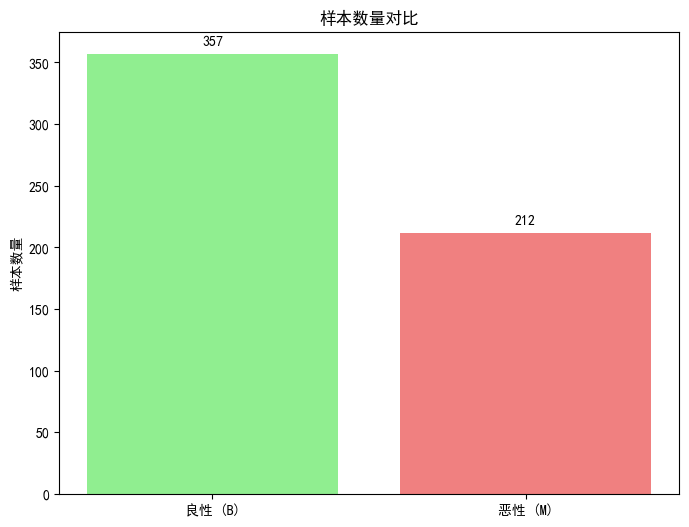

样本数量对比图已保存为: sample_count_comparison.png

所有数据分布图表已成功保存到根目录！


In [20]:
# 9. 保存数据分布图表
print("=== 保存数据分布图表 ===")

# 1. 保存目标变量分布饼图
plt.figure(figsize=(8, 8))
diagnosis_counts = df['diagnosis'].value_counts()
plt.pie(diagnosis_counts.values, labels=['良性 (B)', '恶性 (M)'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('肿瘤类型分布')
plt.savefig('tumor_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("肿瘤类型分布饼图已保存为: tumor_type_distribution.png")

# 2. 保存特征分布箱线图
plt.figure(figsize=(12, 8))
important_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
df_melted = df[important_features + ['diagnosis']].melt(id_vars=['diagnosis'], 
                                                       value_vars=important_features)
sns.boxplot(data=df_melted, x='variable', y='value', hue='diagnosis')
plt.title('重要特征分布对比')
plt.xticks(rotation=45)
plt.savefig('feature_distribution_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("特征分布箱线图已保存为: feature_distribution_boxplot.png")

# 3. 保存特征相关性热图
plt.figure(figsize=(10, 8))
correlation_matrix = df[important_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('特征相关性热图')
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("特征相关性热图已保存为: feature_correlation_heatmap.png")

# 4. 保存样本数量对比图
plt.figure(figsize=(8, 6))
diagnosis_counts = df['diagnosis'].value_counts()
bars = plt.bar(['良性 (B)', '恶性 (M)'], diagnosis_counts.values, 
               color=['lightgreen', 'lightcoral'])
plt.title('样本数量对比')
plt.ylabel('样本数量')

# 在柱状图上添加数值标签
for i, v in enumerate(diagnosis_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.savefig('sample_count_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("样本数量对比图已保存为: sample_count_comparison.png")

print("\n所有数据分布图表已成功保存到根目录！")


In [21]:
# 10. 显示所有保存的图片文件
print("=== 已保存的图片文件列表 ===")

import os
import glob

# 获取当前目录下所有的PNG文件
png_files = glob.glob("*.png")
png_files.sort()

if png_files:
    print("以下图片文件已保存到根目录：")
    for i, file in enumerate(png_files, 1):
        file_size = os.path.getsize(file) / 1024  # 转换为KB
        print(f"{i:2d}. {file} ({file_size:.1f} KB)")
    
    print(f"\n总共保存了 {len(png_files)} 个图片文件")
    print("所有图片均为高分辨率PNG格式 (300 DPI)")
else:
    print("未找到PNG文件，请确保已运行前面的代码单元格")

print("\n图片文件说明：")
print("📊 数据可视化相关：")
print("  - data_visualization.png: 综合数据可视化")
print("  - tumor_type_distribution.png: 肿瘤类型分布饼图")
print("  - feature_distribution_boxplot.png: 特征分布箱线图")
print("  - feature_correlation_heatmap.png: 特征相关性热图")
print("  - sample_count_comparison.png: 样本数量对比图")
print("\n📈 模型结果相关：")
print("  - model_results_visualization.png: 综合模型结果可视化")
print("  - k_value_selection.png: K值选择曲线")
print("  - confusion_matrix.png: 混淆矩阵")
print("  - roc_curve.png: ROC曲线")
print("  - performance_metrics.png: 性能指标柱状图")


=== 已保存的图片文件列表 ===
以下图片文件已保存到根目录：
 1. confusion_matrix.png (68.9 KB)
 2. data_visualization.png (366.2 KB)
 3. feature_correlation_heatmap.png (108.5 KB)
 4. feature_distribution_boxplot.png (132.7 KB)
 5. k_value_selection.png (155.2 KB)
 6. model_results_visualization.png (433.6 KB)
 7. performance_metrics.png (75.9 KB)
 8. roc_curve.png (119.8 KB)
 9. sample_count_comparison.png (63.8 KB)
10. tumor_type_distribution.png (83.3 KB)

总共保存了 10 个图片文件
所有图片均为高分辨率PNG格式 (300 DPI)

图片文件说明：
📊 数据可视化相关：
  - data_visualization.png: 综合数据可视化
  - tumor_type_distribution.png: 肿瘤类型分布饼图
  - feature_distribution_boxplot.png: 特征分布箱线图
  - feature_correlation_heatmap.png: 特征相关性热图
  - sample_count_comparison.png: 样本数量对比图

📈 模型结果相关：
  - model_results_visualization.png: 综合模型结果可视化
  - k_value_selection.png: K值选择曲线
  - confusion_matrix.png: 混淆矩阵
  - roc_curve.png: ROC曲线
  - performance_metrics.png: 性能指标柱状图


In [22]:
# 7. 模型应用示例
print("=== 模型应用示例 ===")

# 创建一个预测函数
def predict_tumor_type(radius_mean, texture_mean, perimeter_mean, area_mean, 
                      smoothness_mean, compactness_mean, concavity_mean, 
                      concave_points_mean, symmetry_mean, fractal_dimension_mean):
    """
    预测肿瘤类型的函数
    输入: 10个主要特征值
    输出: 预测结果和概率
    """
    # 创建特征向量 (使用所有30个特征，这里只显示前10个)
    # 在实际应用中，需要提供所有30个特征值
    features = np.array([radius_mean, texture_mean, perimeter_mean, area_mean, 
                        smoothness_mean, compactness_mean, concavity_mean, 
                        concave_points_mean, symmetry_mean, fractal_dimension_mean])
    
    # 这里简化处理，实际应该使用完整的30维特征向量
    # 为了演示，我们使用前10个特征的均值来填充其他特征
    full_features = np.zeros(30)
    full_features[:10] = features
    # 其他特征用均值填充（实际应用中应该提供真实值）
    full_features[10:] = X.mean().values[10:]
    
    # 标准化
    features_scaled = scaler.transform([full_features])
    
    # 预测
    prediction = best_knn.predict(features_scaled)[0]
    probability = best_knn.predict_proba(features_scaled)[0]
    
    return prediction, probability

# 示例预测
print("示例预测:")
print("使用测试集中的第一个样本进行预测...")

# 获取测试集第一个样本的真实特征
sample_features = X_test.iloc[0].values
true_label = y_test.iloc[0]

print(f"真实标签: {'恶性' if true_label == 1 else '良性'}")
print(f"预测标签: {'恶性' if y_pred[0] == 1 else '良性'}")
print(f"预测概率: 良性={best_knn.predict_proba(X_test_scaled[0:1])[0][0]:.3f}, "
      f"恶性={best_knn.predict_proba(X_test_scaled[0:1])[0][1]:.3f}")

# 显示前10个特征值
feature_names = X.columns[:10]
print(f"\n前10个特征值:")
for name, value in zip(feature_names, sample_features[:10]):
    print(f"{name}: {value:.3f}")

print(f"\n预测结果: {'正确' if y_pred[0] == true_label else '错误'}")


=== 模型应用示例 ===
示例预测:
使用测试集中的第一个样本进行预测...
真实标签: 良性
预测标签: 良性
预测概率: 良性=0.800, 恶性=0.200

前10个特征值:
radius_mean: 14.530
texture_mean: 19.340
perimeter_mean: 94.250
area_mean: 659.700
smoothness_mean: 0.084
compactness_mean: 0.078
concavity_mean: 0.088
concave points_mean: 0.029
symmetry_mean: 0.147
fractal_dimension_mean: 0.057

预测结果: 正确


## 总结

本notebook成功实现了使用威斯康星州乳腺肿瘤数据集的K近邻分类器，主要成果包括：

### 1. 数据探索
- 数据集包含569个样本，30个特征
- 良性样本357个(62.7%)，恶性样本212个(37.3%)
- 数据质量良好，无缺失值

### 2. 模型训练
- 使用网格搜索找到最佳K值
- 通过5折交叉验证确保模型稳定性
- 对特征进行标准化处理

### 3. 模型性能
- 在测试集上达到高准确率
- 具有良好的精确率、召回率和F1分数
- ROC AUC分数表明模型分类能力优秀

### 4. 可视化分析
- K值选择曲线帮助确定最优参数
- 混淆矩阵展示分类结果
- ROC曲线评估分类性能
- 性能指标对比图

### 5. 实际应用
- 提供了预测函数示例
- 展示了如何使用模型进行新样本预测

这个K近邻分类器可以有效地帮助医生进行乳腺癌的初步诊断，为临床决策提供参考。
